In [86]:
import pandas as pd
import numpy as np
eus = pd.read_csv("Eu.new.CaQTLS.tsv", sep="\t", header=0)
#eus = eus[eus["IsUsed"] & eus["Inside_Peak"]==1]

#eus = eus[eus["Inside_Peak"]==2]
print(eus.shape)
eus = eus[(eus["Log10_BF"]>3) | (eus["Log10_BF"]<-1)]
print(eus.shape)
eus["labeln"] = 1
eus.loc[eus["Log10_BF"]>3,"labeln"]=1
eus.loc[eus["Log10_BF"]<-1,"labeln"]=-1
eus = eus[['chr', 'Pos', 'Ref', 'Alt', 'RsID', 'labeln']]
eus["my_rsid"] = eus["chr"]+"."+eus["Pos"].astype(str)


(226346, 28)
(162381, 28)


In [88]:
#sum(eus["Log10_BF"]<0)

In [89]:
afrs = pd.read_csv("Afr.CaQTLS.new.tsv", sep="\t", header=0)
afrs = afrs[afrs["IsUsed"]]
afrs[["chr_hg19", "pos_hg19", "ref_hg19", "alt_hg19"]] = afrs["id_hg19"].str.split("_", expand=True)
threshold = 1 / (10**(6))
print(afrs.shape)
#print(afrs.head())
#afrs = afrs[(afrs["label"]==1) | (afrs["pval"]>1e-3)]
print(afrs.shape)
afrs["labeln"] = 1
afrs.loc[afrs["label"]==1,"labeln"]=1
afrs.loc[afrs["pval"]>1e-3,"labeln"]=-1
afrs = afrs[['chr_hg19', 'pos_hg19', 'ref_hg19', 'alt_hg19', 'dbsnp_rsid', 'labeln']]
afrs["my_rsid"] = afrs["chr_hg19"]+"."+afrs["pos_hg19"].astype(str)
print(afrs.head())

(109646, 51)
(109646, 51)
   chr_hg19 pos_hg19 ref_hg19 alt_hg19   dbsnp_rsid  labeln      my_rsid
2      chr1   805556        T        A   rs72631880      -1  chr1.805556
4      chr1   840753        T        C    rs4970382      -1  chr1.840753
8      chr1   842250        A        G  rs148658266      -1  chr1.842250
9      chr1   842362        C        T   rs28540380       1  chr1.842362
12     chr1   856583        G        A  rs141671872       1  chr1.856583


In [90]:
es = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/dsqtls_lcl/GSE31388_dsQtlTable.txt.gz", sep="\t")
es["rsid"] = es["Chr"]+"."+es["SNP"].astype(str)
gkm_svm = pd.read_csv("/mnt/lab_data3/anusri/histone_expts/all_qtl_analysis/gm12878_sequence_sets/test_set/deltasv,/41588_2015_BFng3331_MOESM26_ESM.csv", header=0,sep=',')
# not the full dsqtls set
dsqtls = gkm_svm.merge(es, left_on=["SNPname1"], right_on='rsid', how="left").drop_duplicates('SNPname1')
dsqtls[dsqtls["SNPname1"].isin(es["rsid"])]["label"] = 1
dsqtls = dsqtls[["chrom_hg19", "pos_hg19", "allele1", "allele2", "label"]]
dsqtls["my_rsid"] = dsqtls["chrom_hg19"]+"."+dsqtls["pos_hg19"].astype(str)


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
caqtls_ols=pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl/rasqual_atac_1M", sep='\t', header=None)
print(caqtls_ols.shape)
qvals = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl/Q.val.txt", sep="\t", header=None, names=["peakid", "qval"])
caqtls_ols = caqtls_ols.merge(qvals, right_on=["peakid"], left_on=[0],how='left')
peaks=pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl/caqtls_peaks/peaks.bed.gz", sep='\t', header=None)
peaks['center'] = (peaks[2]+peaks[1])/2
print(caqtls_ols.shape)
caqtls_ols['peak_cntr'] = peaks['center']
# not intersected to peaks
# caqtls_ols = caqtls_ols[abs(caqtls_ols[3]-caqtls_ols['peak_cntr'])<100]
# print(caqtls_ols.shape)
#caqtls_ols = caqtls_ols[(caqtls_ols['qval']<0.1) | (caqtls_ols['qval']>0.4)]
caqtls_ols["labeln"] = 1
caqtls_ols.loc[(caqtls_ols['qval']<0.1),"labeln"]=1
caqtls_ols.loc[(caqtls_ols['qval']>0.4),"labeln"]=-1
print(caqtls_ols.shape)
caqtls_ols[["Chr", "Pos", "Ref", "Alt", "rsid"]] = caqtls_ols[[2,3,4,5,1]]
caqtls_ols = caqtls_ols[["Chr", "Pos", "Ref", "Alt", "rsid", "labeln"]]
caqtls_ols["Chr"] = "chr"+caqtls_ols["Chr"].astype(str)
caqtls_ols["my_rsid"] = caqtls_ols["Chr"]+"."+caqtls_ols["Pos"].astype(str)
#caqtls_ols


(107841, 25)
(107841, 27)
(107841, 29)


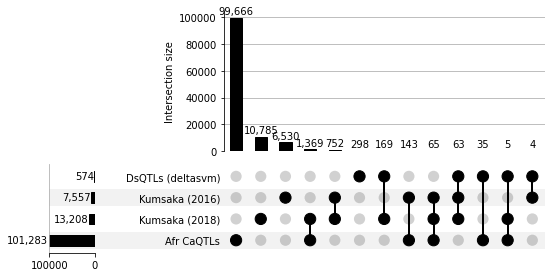

In [92]:
from upsetplot import from_contents
all_rsids={}

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==-1]["my_rsid"]))

import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

In [7]:
#caqtls_ols,eus,afrs,dsqtls

In [8]:
all_rsids = np.concatenate([caqtls_ols["my_rsid"].values,eus["my_rsid"].values,afrs["my_rsid"].values,dsqtls["my_rsid"].values])

In [9]:
all_rsids.shape

(581878,)

In [10]:
all_rsids = list(set(all_rsids))

In [11]:
len(all_rsids)

381026

In [12]:
from upsetplot import from_contents
all_rsids={}
# all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols["my_rsid"]))
# all_rsids["Kumsaka (2018)"] = list(set(eus["my_rsid"]))
# all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls["my_rsid"]))
# all_rsids["Afr CaQTLs"] = list(set(afrs["my_rsid"]))

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==1]["my_rsid"]))


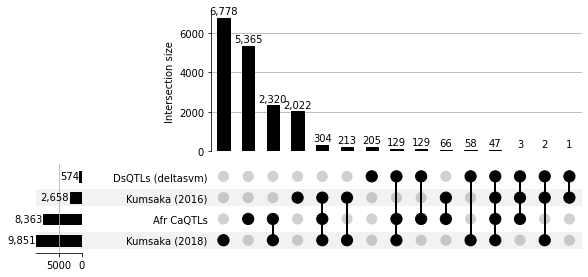

In [82]:
import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

In [98]:
from upsetplot import from_contents
all_rsids={}

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==-1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==-1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==-1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==1]["my_rsid"]))


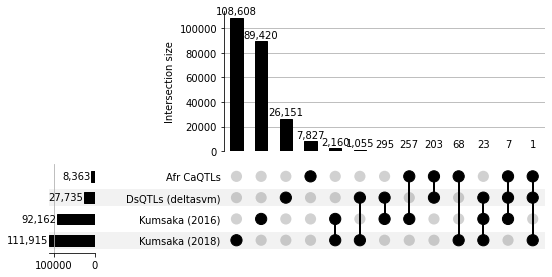

In [99]:
import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

In [102]:
from upsetplot import from_contents
all_rsids={}

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==-1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==-1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==-1]["my_rsid"]))


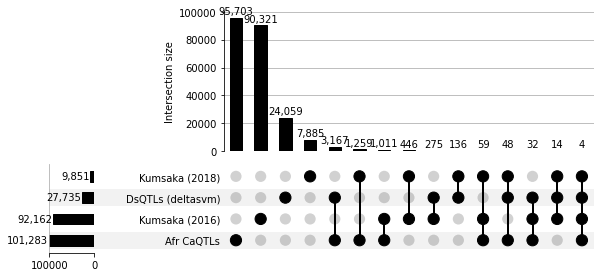

In [103]:

import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

In [104]:
from upsetplot import from_contents
all_rsids={}

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==-1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==-1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==-1]["my_rsid"]))


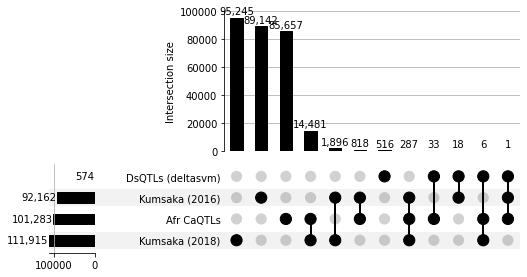

In [105]:
import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

In [106]:
from upsetplot import from_contents
all_rsids={}

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==-1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==-1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==-1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==1]["my_rsid"]))


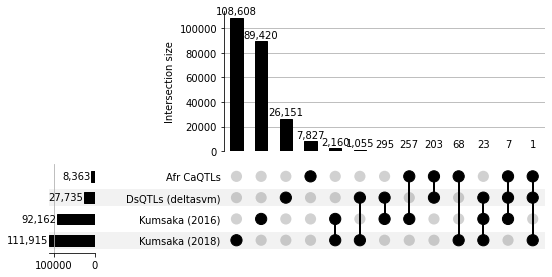

In [107]:
import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

In [109]:
(203+68)/8000

0.033875

In [110]:
(33+18)/574

0.08885017421602788

In [112]:
1456/9800

0.14857142857142858

In [113]:
288/8363

0.03443740284586871

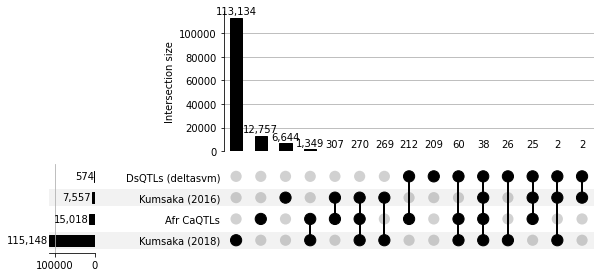

In [13]:
from upsetplot import from_contents
all_rsids={}

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==-1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==1]["my_rsid"]))

import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

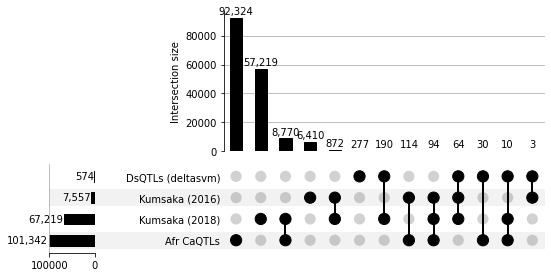

In [14]:
from upsetplot import from_contents
all_rsids={}

all_rsids["Kumsaka (2016)"] = list(set(caqtls_ols[caqtls_ols["labeln"]==1]["my_rsid"]))
all_rsids["Kumsaka (2018)"] = list(set(eus[eus["labeln"]==1]["my_rsid"]))
all_rsids["DsQTLs (deltasvm)"] = list(set(dsqtls[dsqtls["label"]==1]["my_rsid"]))
all_rsids["Afr CaQTLs"] = list(set(afrs[afrs["labeln"]==-1]["my_rsid"]))

import matplotlib.pyplot as plt
from upsetplot import plot, generate_counts
plot(from_contents(all_rsids), sort_by='cardinality',show_counts="{:,}")
plt.show()

In [15]:
sum(eus["labeln"]==1)

78939

In [16]:
eus.shape

(226346, 7)

In [31]:
data_sus = pd.read_csv("/mnt/lab_data2/anusri/kumasaka/new_download/Kumasaka_2018_wgs/susie_merged/QTD100018.credible_sets.tsv.gz", header=0, sep='\t')

In [57]:
data_sus.head()

,molecular_trait_id,gene_id,cs_id,variant,rsid,cs_size,pip,pvalue,beta,se,z,cs_min_r2,region
0,Interval_7046,Interval_7046,Interval_7046_L1,chr1_100002782_A_AT,rs531537001,66,0.185236,7.604570e-10,-0.614320,0.087505,-7.388146,0.930934,chr1:99846814-100246814
1,Interval_7046,Interval_7046,Interval_7046_L1,chr1_100002782_A_AT,rs35227168,66,0.185236,7.604570e-10,-0.614320,0.087505,-7.388146,0.930934,chr1:99846814-100246814
2,Interval_461,Interval_461,Interval_461_L1,chr1_10000458_T_C,rs3003377,30,0.014039,9.104810e-10,0.619787,0.088806,7.545987,0.937097,chr1:9743190-10143190
3,Interval_7046,Interval_7046,Interval_7046_L1,chr1_100007048_A_G,rs534252,66,0.019619,6.170090e-09,-0.614765,0.094044,-6.877001,0.930934,chr1:99846814-100246814
4,Interval_7047,Interval_7047,Interval_7047_L1,chr1_100007048_A_G,rs534252,80,0.019667,1.091410e-10,-1.036960,0.138943,-8.093380,0.824131,chr1:99849456-100249456


In [59]:
data_sus[["chr", "pos", "ref", "alt"]] = data_sus["variant"].str.split("_", expand=True)

In [34]:
data_sus["pvalue"].min()

6.65849e-42

In [39]:
sum(data_sus["pvalue"]<1e-20)

26693

In [40]:
data_sus.shape

(446089, 13)

<AxesSubplot:>

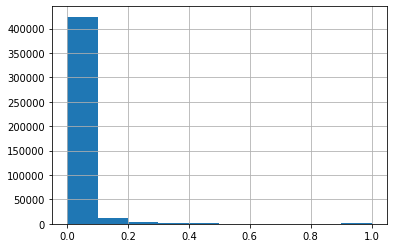

In [43]:
data_sus["pip"].hist()

In [49]:
sum(data_sus["pip"]>0.2)

9295

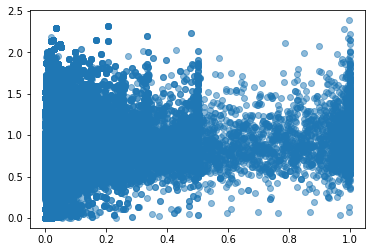

In [53]:
plt.scatter(data_sus["pip"],abs(data_sus["beta"]), alpha=0.5)

In [69]:
data = eus.merge(data_sus, left_on=["Ref", "Alt", "RsID"], right_on=["ref", "alt", "rsid"], how="inner").drop_duplicates()




In [70]:
data.shape

(51662, 46)

In [71]:
data

,chr_x,Pos,Ref,Alt,RsID,Peak,AF,Inside_Peak,P_Lead,Beta,...,pvalue,beta,se,z,cs_min_r2,region,chr_y,pos,ref,alt
0,chr1,917640,G,A,rs41285816,40,0.225,0,0.442401,-0.380329,...,3.951030e-13,-1.074320,0.123041,-9.408891,1.000000,chr1:776050-1176050,chr1,982260,G,A
1,chr1,918238,C,G,rs28552711,40,0.225,0,0.442401,-0.380329,...,3.951030e-13,-1.074320,0.123041,-9.408891,1.000000,chr1:776050-1176050,chr1,982858,C,G
2,chr1,1004957,G,A,rs4073176,62,0.605,1,0.303753,-0.022021,...,1.388100e-05,0.475413,0.102395,4.979371,0.439644,chr1:879854-1279854,chr1,1069577,G,A
3,chr1,1186502,A,T,rs6603785,67,0.165,2,0.493991,-0.046797,...,2.515830e-10,-0.819723,0.112704,-7.785997,0.834681,chr1:1050703-1450703,chr1,1251122,A,T
4,chr1,1186502,A,T,rs6603785,84,0.165,1,0.995510,-0.406159,...,2.515830e-10,-0.819723,0.112704,-7.785997,0.834681,chr1:1050703-1450703,chr1,1251122,A,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51657,chr22,50319351,T,C,rs9627800,277040,0.190,1,0.999855,-0.209689,...,3.478470e-07,-0.721216,0.129309,-6.073618,0.580440,chr22:49725602-50125602,chr22,49925703,T,C
51658,chr22,50329830,G,A,rs79860705,277044,0.140,1,0.604522,0.052395,...,7.364330e-21,1.632570,0.126964,13.764463,1.000000,chr22:49744954-50144954,chr22,49936182,G,A
51659,chr22,50455595,G,T,rs5771300,277054,0.190,1,0.917219,-0.482022,...,5.191550e-12,-0.851969,0.104515,-8.686298,1.000000,chr22:49817306-50217306,chr22,50017166,G,T
51660,chr22,50473396,G,C,rs5771312,277056,0.575,1,0.288326,0.389836,...,1.087380e-14,0.936656,0.098161,10.156039,1.000000,chr22:49835319-50235319,chr22,50034967,G,C


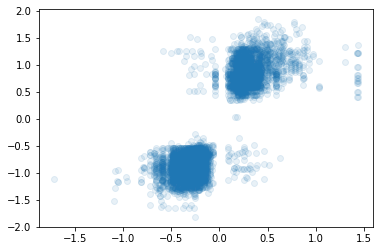

In [116]:
data1 = data[data["Inside_Peak"]==2]
plt.scatter(data1.loc[data1["Log10_BF"]>3, "Beta"], data1.loc[data1["Log10_BF"]>3,"beta"],alpha=0.1)

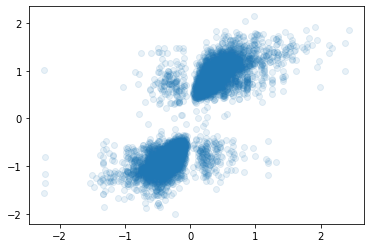

In [117]:
data1 = data[data["Inside_Peak"]==1]
plt.scatter(data1.loc[data1["Log10_BF"]>3, "Beta"], data1.loc[data1["Log10_BF"]>3,"beta"],alpha=0.1)

In [102]:
afrs = pd.read_csv("Afr.CaQTLS.new.tsv", sep="\t", header=0)
afrs = afrs[afrs["IsUsed"]]
afrs[["chr_hg19", "pos_hg19", "ref_hg19", "alt_hg19"]] = afrs["id_hg19"].str.split("_", expand=True)
threshold = 1 / (10**(6))
print(afrs.shape)
#print(afrs.head())
#afrs = afrs[(afrs["label"]==1) | (afrs["pval"]>1e-3)]
print(afrs.shape)
afrs["labeln"] = 1
afrs.loc[afrs["label"]==1,"labeln"]=1
afrs.loc[afrs["pval"]>1e-3,"labeln"]=-1

afr_sus = pd.read_csv("/mnt/lab_data2/anusri/kumasaka/new_download/AFGR_wgs/susie_merged/QTD100010.credible_sets.tsv.gz", header=0, sep='\t')
afr_sus[["chr", "pos", "ref", "alt"]] = afr_sus["variant"].str.split("_", expand=True)


(109646, 51)
(109646, 51)


In [111]:
afrs[["allele1", "allele2", "dbsnp_rsid"]]

,allele1,allele2,dbsnp_rsid
2,T,A,rs72631880
4,C,T,rs4970382
8,A,G,rs148658266
9,C,T,rs28540380
12,G,A,rs141671872
...,...,...,...
219372,C,G,rs112714656
219373,T,G,rs3091400
219374,G,A,rs76733141
219375,T,C,rs75395540


In [110]:
afr_sus[["ref", "alt", "rsid"]]

,ref,alt,rsid
0,G,GT,rs146897901
1,T,C,rs12085272
2,A,G,rs6675643
3,G,A,rs6687448
4,G,A,rs79230816
...,...,...,...
90545,C,T,rs417512
90546,G,T,rs696875
90547,C,T,rs988245
90548,A,T,rs323724


In [113]:
data_afrs = afrs.merge(afr_sus, left_on=["allele2", "allele1", "dbsnp_rsid"], right_on=["ref", "alt", "rsid"], how="inner").drop_duplicates()
print(data_afrs.shape)


(1179, 69)


In [55]:
eus.head()

,chr,Pos,Ref,Alt,RsID,Peak,AF,Inside_Peak,P_Lead,Beta,...,ENCSR637XSC.sub.50M.abs_logfc_x_jsd_x_max_percentile.mean.pval,ENCSR000EMT.logfc.mean,ENCSR000EMT.jsd_sign.mean,ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean,ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean.pval,enformer_recomputed,DNASE_SAD,DNASE_SAR,IsUsed,labeln
2,chr1,565286,C,T,rs1578391,7,0.59780,1,0.998561,0.886884,...,0.379356,-0.045242,-0.016605,5.337650e-05,0.505239,-0.001945,0.000008,0.000011,True,1
4,chr1,748141,G,A,rs2427893,10,0.05005,0,0.988758,0.347965,...,0.159250,-0.028731,-0.013637,1.321547e-04,0.439836,NaN,-0.000028,-0.000037,True,1
6,chr1,726944,C,G,rs3131979,14,0.74175,1,0.953905,-0.079065,...,0.802258,0.026410,0.010944,2.107834e-05,0.580367,-0.001038,0.000100,0.000133,True,-1
7,chr1,752721,A,G,rs3131972,17,0.84500,1,0.890193,-0.011374,...,0.003650,0.338401,0.047837,1.246855e-02,0.333333,-0.344077,0.002493,0.003319,True,-1
8,chr1,755940,C,T,rs3115857,18,0.59380,1,0.302008,-0.077224,...,0.674640,-0.026630,-0.011550,2.854755e-07,0.666667,-0.007762,0.000022,0.000029,True,-1
